In [1]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.18.0
/device:GPU:0
Num GPUs Available:  1


In [2]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [3]:
# Moving kaggle.json to /root/.kaggle directory to make things work
!mkdir /root/.kaggle
!cp 'gdrive/My Drive/Colab Notebooks/Files For Colab/kaggle.json' '/root/.kaggle'
!ls /root/.kaggle

cp: cannot stat 'gdrive/My Drive/Colab Notebooks/Files For Colab/kaggle.json': No such file or directory


In [4]:
# Downloading the kaggle ASL alphabet signs dataset
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100% 1.02G/1.03G [00:10<00:00, 92.3MB/s]
100% 1.03G/1.03G [00:10<00:00, 105MB/s] 


In [5]:
# Check out your brand new downloaded dataset
!ls

asl-alphabet.zip  drive  sample_data


In [6]:
# Make it a new directory to settle amd unzip it
!mkdir asl_data
!unzip -qq -o asl-alphabet.zip

In [7]:
# Delete the zip file
!rm asl-alphabet.zip

In [8]:
# Move it to our new directory to keep it organized
!mv asl_alphabet_test asl_data/
!mv asl_alphabet_train asl_data/

In [9]:
# Bước 1: Cài đặt các thư viện cần thiết
!pip install tensorflow opencv-python gtts scikit-learn seaborn


In [10]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
import os
data='/content/asl_data/asl_alphabet_train/asl_alphabet_train'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)

    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)

            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

In [12]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


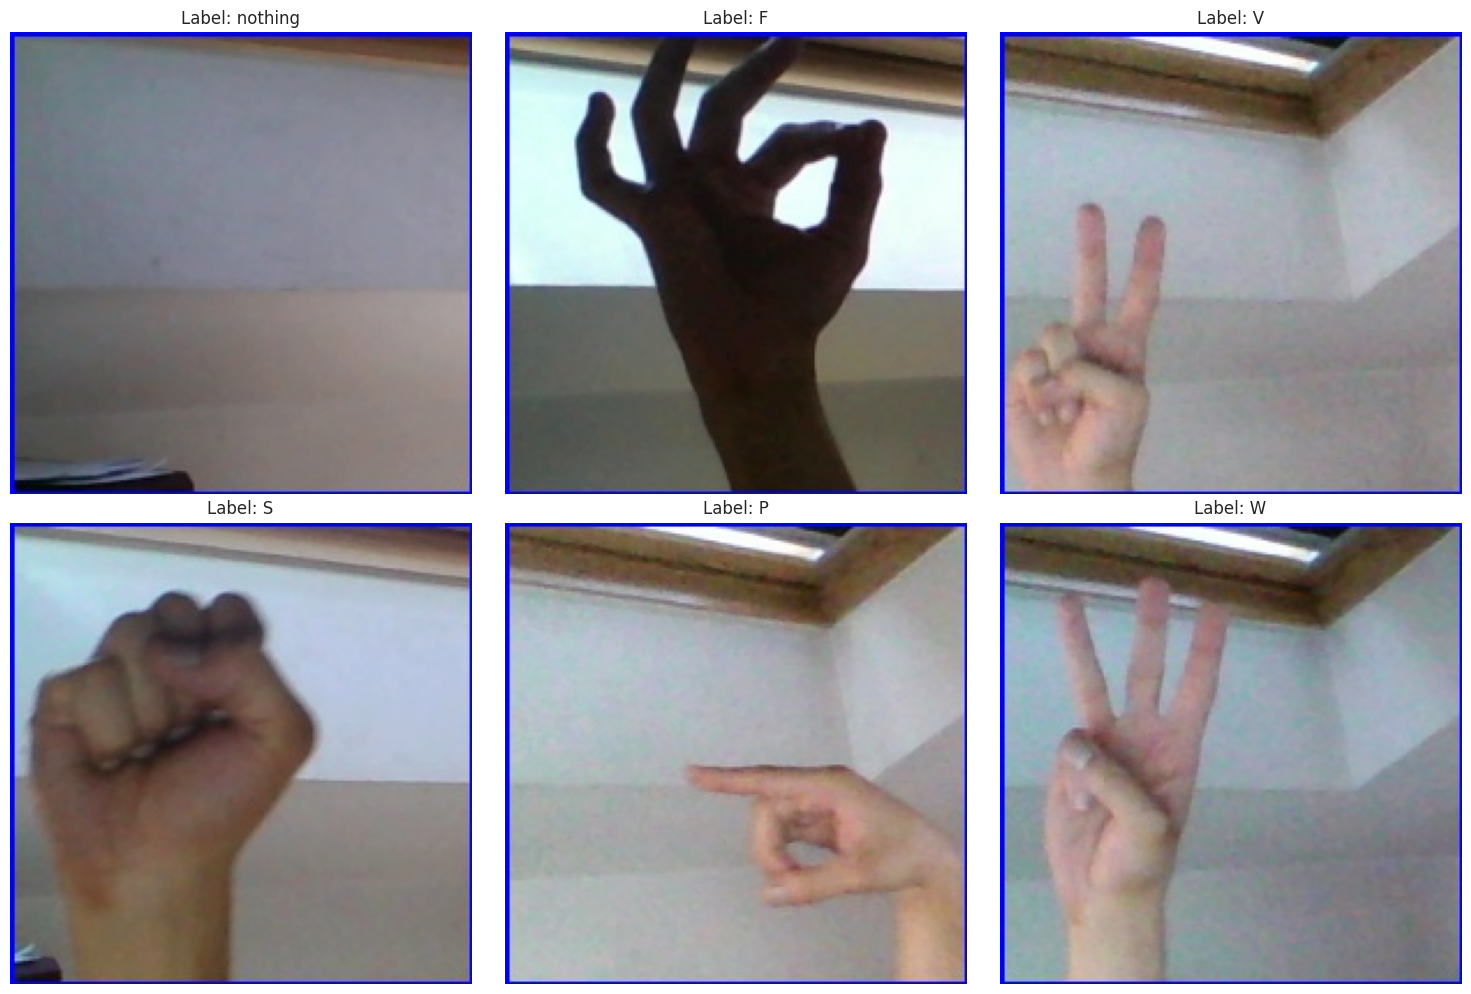

In [14]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']

        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

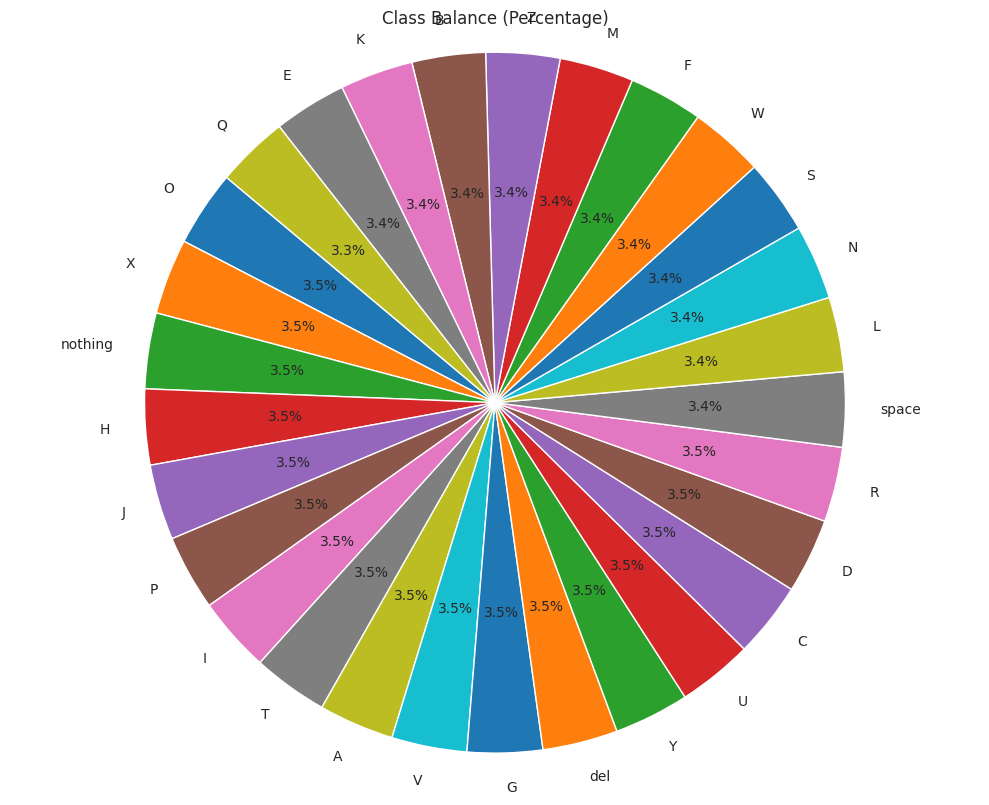

In [15]:
# Calculate class counts
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(train_df)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Create the pie chart using matplotlib
plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [ ]:
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (150,150,3) ,
                                                     pooling = 'max' )

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(29 , activation= 'softmax' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
history = model.fit(
    x= train_generator ,
    validation_data= valid_generator ,
    epochs= 5 , verbose = 1 ,
    validation_steps= None, shuffle= False
   )

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 629s 410ms/step - accuracy: 0.8045 - loss: 0.7706 - val_accuracy: 0.9967 - val_loss: 0.0122
Epoch 2/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 567s 408ms/step - accuracy: 0.9787 - loss: 0.0800 - val_accuracy: 0.9971 - val_loss: 0.0093
Epoch 3/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 620s 406ms/step - accuracy: 0.9858 - loss: 0.0536 - val_accuracy: 0.9990 - val_loss: 0.0028
Epoch 4/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 619s 404ms/step - accuracy: 0.9885 - loss: 0.0446 - val_accuracy: 0.9999 - val_loss: 2.7165e-04
Epoch 5/5
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 562s 404ms/step - accuracy: 0.9907 - loss: 0.0362 - val_accuracy: 0.9943 - val_loss: 0.0274


In [16]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/superAI.h5')  # hoặc 'ten_file.keras'

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

174/174 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9939 - loss: 0.0317
Test Accuracy: 0.9931034445762634


In [ ]:
import json

# Lưu history vào file JSON
with open('/content/drive/MyDrive/Colab Notebooks/history.json', 'w') as f:
    json.dump(history.history, f)


In [ ]:
# Tải lại history từ file JSON
with open('history.json', 'r') as f:
    loaded_history = json.load(f)


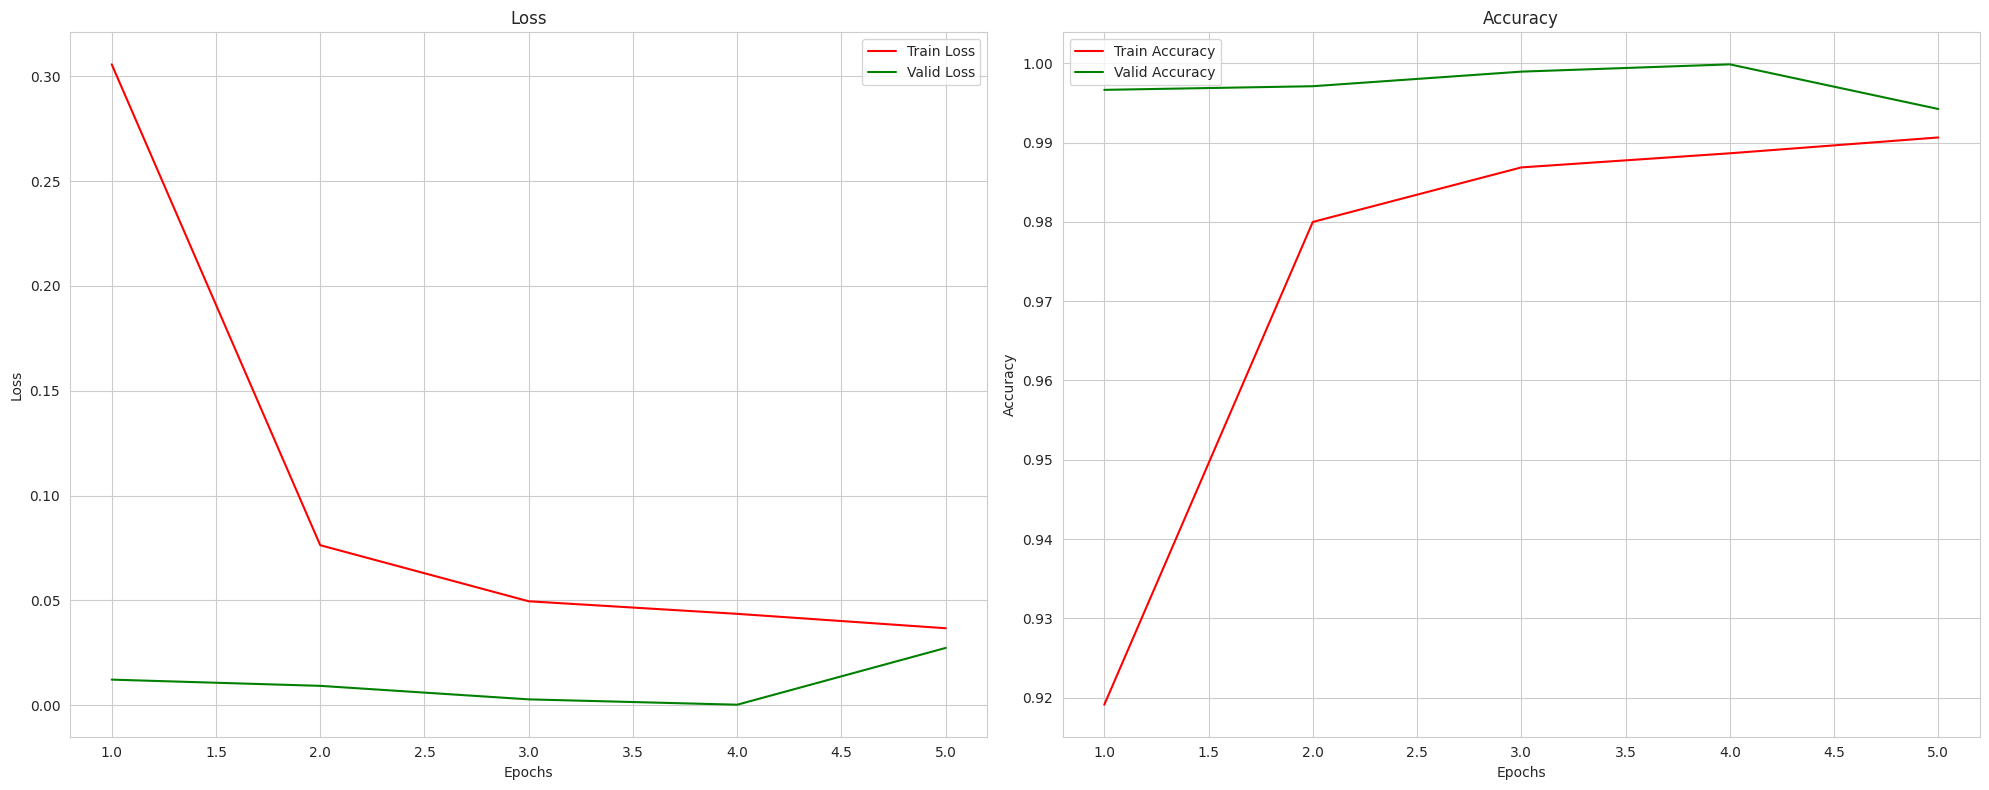

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Bước 10: Lưu mô hình
model.save('/content/drive/MyDrive/Colab Notebooks/superAI.h5')
print("Model saved as SuperAI.h5")

Model saved as SuperAI.h5


In [18]:
# Bước 11: Tích hợp Text-to-Speech (TTS)
!pip install gTTS # install the missing gTTS module
from gtts import gTTS # import the gTTS module to make it accessible
from IPython.display import Audio # Import Audio to play the output
import IPython.display as ipd # import the ipd to be used later
def text_to_speech(text, lang='en'):
    tts = gTTS(text=text, lang=lang)
    tts.save("output.mp3")
    ipd.display(ipd.Audio("output.mp3", autoplay=True))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Dự đoán: A, Độ tin cậy: 1.00


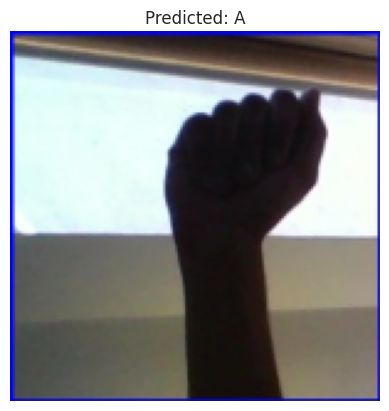

In [ ]:
# Load các nhãn lớp từ train_generator
class_labels = list(train_generator.class_indices.keys())

# Hàm để dự đoán hình ảnh
def predict_sign(model, img_path):
    # Load và xử lý ảnh
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0  # Chuẩn hóa về [0, 1]
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension

    # Dự đoán
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)

    # Lấy nhãn dự đoán
    label = class_labels[predicted_class]
    return label, confidence, img # Return the image as well


# Test thử với 1 ảnh
import matplotlib.pyplot as plt

test_image = '/content/asl_data/asl_alphabet_test/asl_alphabet_test/A_test.jpg'  # Đổi path tới hình bạn muốn test
label, confidence, img = predict_sign(model, test_image) # Get the image from the function
print(f"Dự đoán: {label}, Độ tin cậy: {confidence:.2f}")

# Hiển thị ảnh và kết quả
plt.imshow(img[0]) # Display the image using matplotlib
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()

# Phát âm thanh kết quả
# The 'label' variable holds the predicted label, so pass it to text_to_speech
text_to_speech(label)

In [ ]:
import cv2

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (150, 150))  # Resize theo kích thước model
        frames.append(frame)
    cap.release()
    return frames


In [ ]:
import numpy as np

def predict_frames(frames, model):
    predictions = []
    for frame in frames:
        frame = frame / 255.0  # Rescale như lúc train
        frame = np.expand_dims(frame, axis=0)  # Thêm batch dimension
        pred = model.predict(frame)
        predictions.append(np.argmax(pred))
    return predictions


174/174 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step


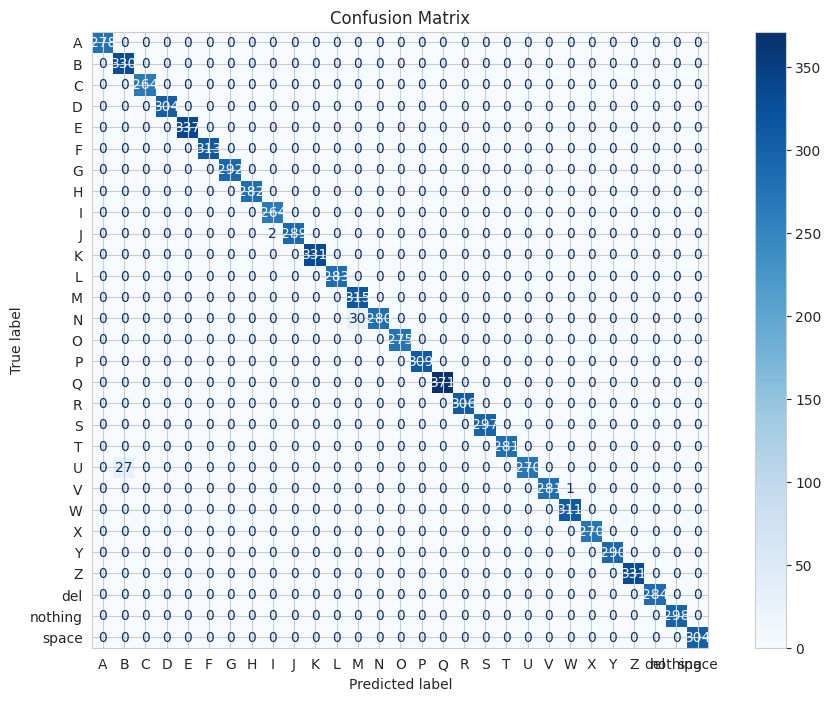

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       278
           B       0.92      1.00      0.96       330
           C       1.00      1.00      1.00       264
           D       1.00      1.00      1.00       304
           E       1.00      1.00      1.00       337
           F       1.00      1.00      1.00       313
           G       1.00      1.00      1.00       292
           H       1.00      1.00      1.00       282
           I       0.99      1.00      1.00       264
           J       1.00      0.99      1.00       291
           K       1.00      1.00      1.00       331
           L       1.00      1.00      1.00       283
           M       0.91      1.00      0.95       315
           N       1.00      0.90      0.95       310
           O       1.00      1.00      1.00       275
           P       1.00      1.00      1.00       309
           Q       1.00      1.00      1.00       371
    

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions from the test generator
test_generator.reset()  # Ensure generator is at the start
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_labels))
